## Семинар 5: "Улучшение сходимости нейросетей"

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:

1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**



### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [51]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [52]:
images_train, labels_train = next(iter(train_loader))

In [53]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

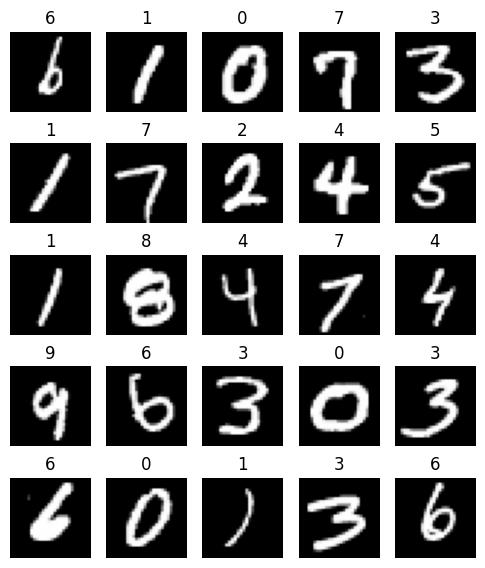

In [54]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [55]:
def init_layer_he(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [56]:
layer_1_he = nn.Linear(28*28, 500)
layer_2_he = nn.Linear(500, 10)

layer_1_he.register_forward_hook(forward_hook)
layer_2_he.register_forward_hook(forward_hook)

layer_1_he.register_backward_hook(backward_hook)
layer_2_he.register_backward_hook(backward_hook)

init_layer_he(layer_1_he)
init_layer_he(layer_2_he)

Соберем все вместе, используя ReLU в качестве функции активации:

In [57]:
network_he = nn.Sequential(
    layer_1_he,
    nn.ReLU(),
    layer_2_he
)

#### 1.1 Реализуем инициализацию Xavier. Далее сравним ее с He. Стоит учесть, что для Xavier необходимо использовать функцию активации nn.Tanh()

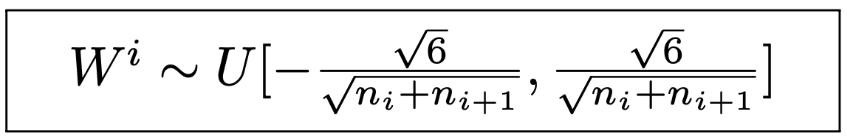

In [58]:
def init_layer_xavier(layer, n_in, n_out):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()

    bound = (6**0.5) / ( (n_in + n_out) **0.5 )
    weight.uniform_(-bound, bound)


def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [59]:
layer_1_xavier = nn.Linear(28*28, 500)
layer_2_xavier = nn.Linear(500, 10)

layer_1_xavier.register_forward_hook(forward_hook)
layer_2_xavier.register_forward_hook(forward_hook)

layer_1_xavier.register_backward_hook(backward_hook)
layer_2_xavier.register_backward_hook(backward_hook)

init_layer_xavier(layer_1_xavier , 28*28, 500)
init_layer_xavier(layer_2_xavier, 500, 10)

Протестируем работу НС с различными инициализациями весов

In [60]:
def step_test(network):
  n_objects = 100
  X = images_train[:n_objects].view(n_objects, -1).data
  y = labels_train[:n_objects].data
  activations = network(X)
  loss_fn = torch.nn.NLLLoss()
  optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
  loss = loss_fn(activations, y)
  loss.backward()

НС с инициализацией Ксавье

In [61]:
network_xavier = nn.Sequential(
    layer_1_xavier,
    nn.Tanh(),
    layer_2_xavier
)

Проверим работу:

In [62]:
step_test(network_he)

forward 1.0145776271820068
forward 16.119108200073242
backward 0.01414213702082634
backward 0.17796625196933746


In [63]:
step_test(network_xavier)

forward 1.0145776271820068
forward 0.6603153944015503
backward 0.01414213702082634
backward 0.011564712971448898


Видно, что второй backward при инициализации xavier ниже по значению, чем backward при инициализации he, однако стоит отметить, что xavier используется только с симметричными относительно нуля функциями активации, а значит, не подходит для ReLU


## Часть 2: DropConnect

#### 2.1 Реализуем DropConnect по следующему шаблону:

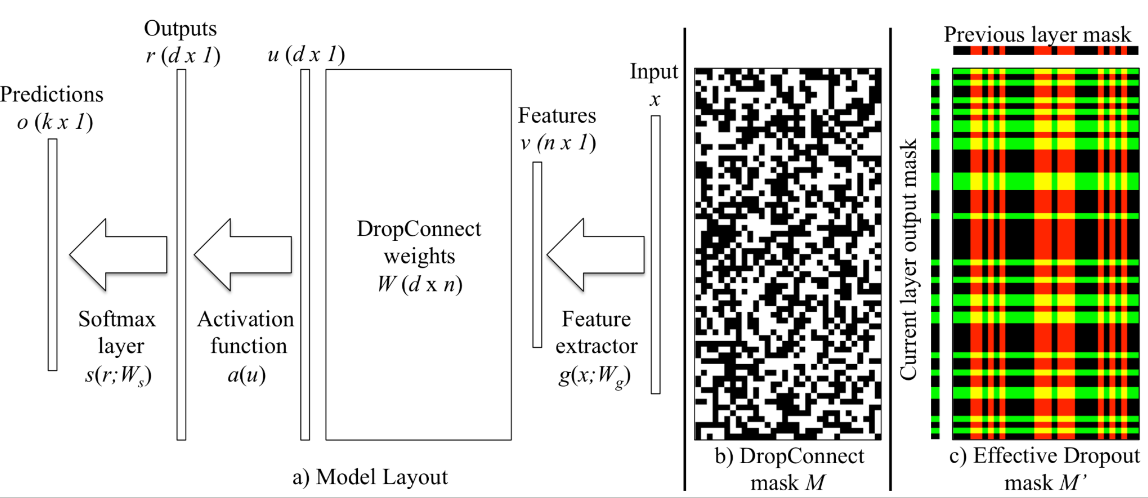

In [79]:

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):

        if self.training:
            mask = torch.empty(self.linear.weight.shape, requires_grad=False).bernoulli_(self.p)
        else:
            mask = torch.ones(self.linear.weight.shape)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [80]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Функция обучения

In [112]:
def train(network, optimizer, loss, train_loader, test_loader):
  optimizer = optimizer
  loss_fn = loss

  losses_train = []
  losses_test = []
  for epoch in range(10):
      loss_tr = []
      loss_ts = []
      network.train()
      for batch_idx, (images_train, labels_train) in enumerate(train_loader):
          optimizer.zero_grad()
          X = images_train.data
          y = labels_train.data
          output = network(X)
          loss = loss_fn(output, y)
          loss.backward()
          optimizer.step()

          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(X), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
              loss_tr.append(loss.item())
      losses_train.append(np.mean(loss_tr))


      network.eval()

      for batch_idx, (images_test, labels_test) in enumerate(test_loader):
          X = images_test.data
          y = labels_test.data
          output = network(X)
          loss = loss_fn(output, y)

          loss_ts.append(loss.item())

      print('Test Epoch: {}\tLoss: {:.6f}'.format(
              epoch, np.mean(loss_ts)))
      losses_test.append(np.mean(loss_ts))
  return losses_train, losses_test


Добавим несколько слоев в конец сети:

In [113]:
layers_dropconnect = [

    DropConnect(196,128, p=0.5),
    nn.ReLU(),
    DropConnect(128,128, p=0.5),
    nn.ReLU(),
    DropConnect(128,10, p=0.5),


]

Обучим получившуюся сеть:

In [114]:
loss = torch.nn.NLLLoss()

In [115]:
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)


loss_train_dropconnect, loss_test_dropconnect = train(network_dropconnect, optimizer_dropconnect, loss, train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308822
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.539315
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.009647
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.809139
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.669170
Test Epoch: 0	Loss: 1.825907
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.682883
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.788814
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.611037
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.869588
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.662609
Test Epoch: 1	Loss: 1.240130
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.567301
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.442105
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.362516
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.571915
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.364691
Test Epoch: 2	Loss: 1.060809
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.322789
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.445695
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.325489
Train Epoch: 3 [38400/60000 (64%)

Обучим сеть с Dropout между всеми слоями


In [116]:
layers_dropout = [

    nn.Linear(196,128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128,10),


]

In [117]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)


loss_train_dropout, loss_test_dropout = train(network_dropout, optimizer_dropout, loss, train_loader, test_loader)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300780
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.746675
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.478632
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.513424
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.248933
Test Epoch: 0	Loss: 0.208883
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.429681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.255440
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.330272
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.253024
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.289603
Test Epoch: 1	Loss: 0.143824
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.253599
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.407278
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.306392
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.303288
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.187155
Test Epoch: 2	Loss: 0.116808
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.269456
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.241040
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.201734
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравним графики обучения нейроных сетей 
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


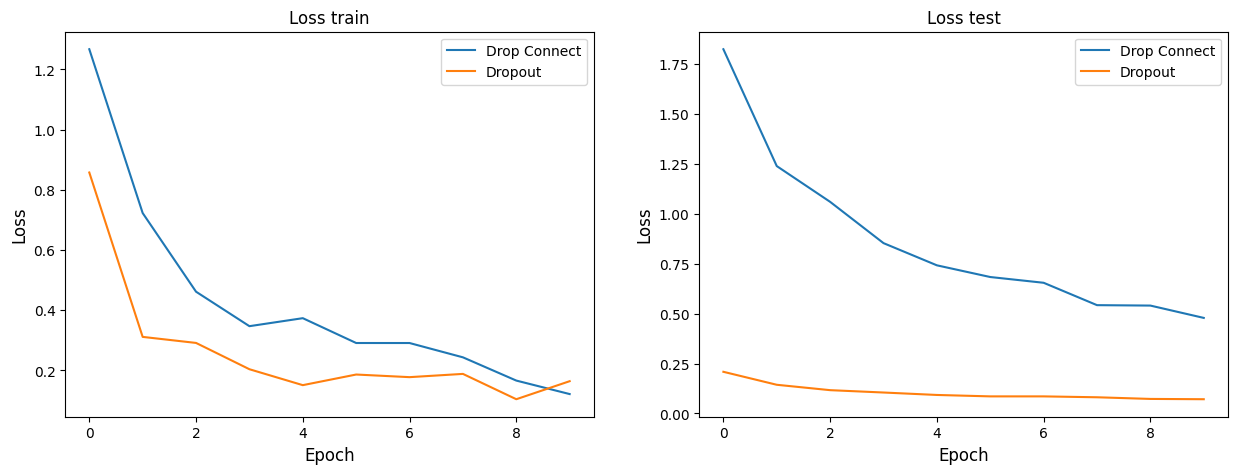

In [118]:
fig, ax = plt.subplots(1, 2 , figsize = (15,5))
ax[0].plot(loss_train_dropconnect, label = "Drop Connect")
ax[0].plot(loss_train_dropout, label = "Dropout")
ax[0].set_title('Loss train')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].legend()


ax[1].plot(loss_test_dropconnect, label = "Drop Connect")
ax[1].plot(loss_test_dropout, label = "Dropout")

ax[1].set_title('Loss test')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()

plt.show()

Видно, что loss drop connect сходится несколько хуже, чем loss dropout.

### Часть 3: Batch Normalization

Рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

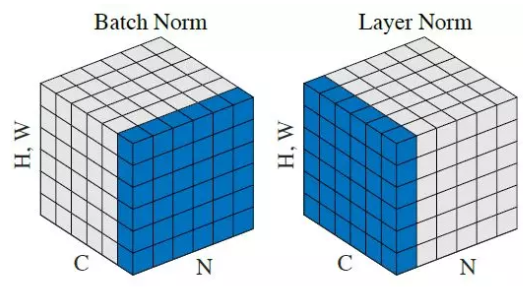

#### 3.1 Реализуем Layer Normalization

In [119]:
class LayerNormalization(nn.Module):

    def __init__(self, channels):
      super().__init__()
      self.eta = 1e-8
      self.gamma = nn.Parameter(torch.ones(channels,1,1), requires_grad=True)
      self.beta = nn.Parameter(torch.zeros(channels,1,1), requires_grad=True)

    def forward(self, x):
      m = x.mean(dim = (-2,-1), keepdim = True)
      std = x.std(dim = (-2,-1), keepdim = True)
      x =( (x - m) / (std +self.eta) )*  self.gamma.unsqueeze(0) + self.beta.unsqueeze(0)
      return x

#### 3.2 Сравним графики обучения нейроных сетей
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [120]:
class TestBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(2),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(4),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.linear_part = nn.Sequential(
            nn.Linear(196,128),
            nn.Linear(128,10),
        )


        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.linear_part(x)
        return self.log_softmax(x)

In [121]:
class TestLayerNorm(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 1

        self.conv_layers1 = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            LayerNormalization(2),

            )
        self.conv_layers2   = nn.Sequential(

            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            LayerNormalization(4),
          )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.linear_part = nn.Sequential(
            nn.Linear(196,128),
            nn.Linear(128,10),
        )


        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):


        x = self.conv_layers1(x)
        x = self.conv_layers2(x)
        x = self.flatten(x)
        x = self.linear_part(x)
        return self.log_softmax(x)

In [122]:

nn_layer_norm = TestLayerNorm()
optimizer_layer_norm = torch.optim.Adam(nn_layer_norm.parameters(), lr=0.001)
losses_train_layer_norm, losses_test_layer_norm = train(nn_layer_norm, optimizer_layer_norm, loss , train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.258779
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.396626
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.221384
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.206090
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.173105
Test Epoch: 0	Loss: 0.150482
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.178424
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.127280
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.072740
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090723
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.105763
Test Epoch: 1	Loss: 0.119236
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.120970
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.150741
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.083940
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.188627
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.165609
Test Epoch: 2	Loss: 0.101555
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.091209
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.059537
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.082764
Train Epoch: 3 [38400/60000 (64%)

In [123]:
nn_batch_norm = TestBatchNorm()
optimizer_batch_norm = torch.optim.Adam(nn_batch_norm.parameters(), lr=0.001)
losses_train_batch_norm, losses_test_batch_norm = train(nn_batch_norm,optimizer_batch_norm, loss, train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.345538
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.267672
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.268742
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.192176
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.158116
Test Epoch: 0	Loss: 0.124513
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.074784
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.273434
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.078886
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.105611
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.079709
Test Epoch: 1	Loss: 0.104206
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.140402
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.136301
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.085979
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.094642
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.140333
Test Epoch: 2	Loss: 0.095168
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.062448
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.028630
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.160144
Train Epoch: 3 [38400/60000 (64%)

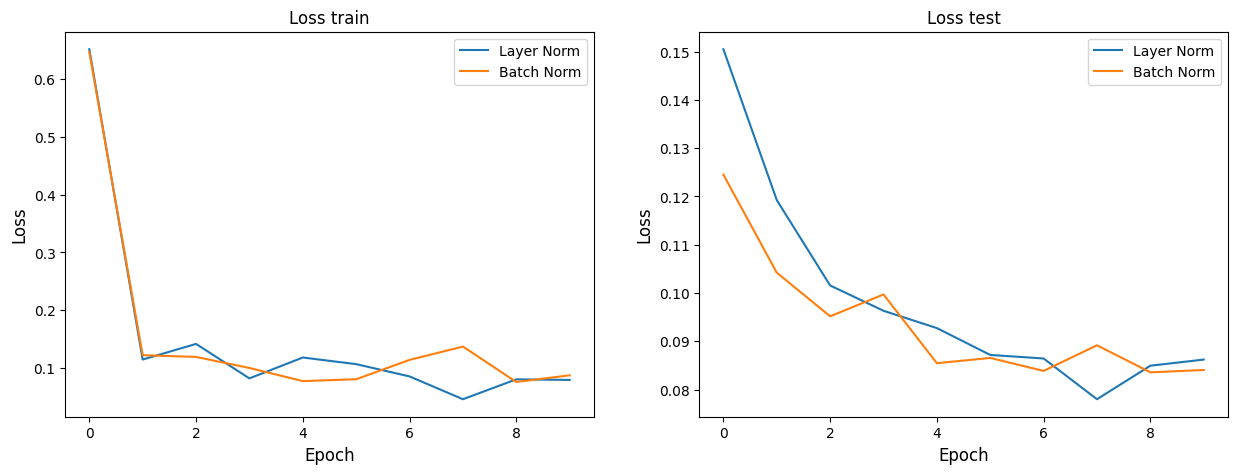

In [124]:
fig, ax = plt.subplots(1, 2 , figsize = (15,5))
ax[0].plot(losses_train_layer_norm, label = "Layer Norm")
ax[0].plot(losses_train_batch_norm, label = "Batch Norm")
ax[0].set_title('Loss train')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].legend()

ax[1].plot(losses_test_layer_norm, label = "Layer Norm")
ax[1].plot(losses_test_batch_norm, label = "Batch Norm")
ax[1].set_title('Loss test')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()

plt.show()

Видно, что layer norm показывает loss на test выборке меньше, чем batch norm. Это круто. Значит, данное решение конкурентноспособно и может использоваться в реальных задачах